&copy; 2019 by Pearson Education, Inc. All Rights Reserved. The content in this notebook is based on the book [**Python for Programmers**](https://amzn.to/2VvdnxE).

# 16. Big Data: Hadoop, Spark, NoSQL and IoT 

In [1]:
# enable high-res images in notebook 
%config InlineBackend.figure_format = 'retina'

# 16.6 Spark
* Use **PySpark** and **Spark functional-style programming** to summarize **word frequencies** in **Romeo and Juliet**
* **Hadoop** break tasks into pieces that do **lots of disk I/O across many computers**
* **Spark** performs certain big-data tasks **in memory** for **better performance**

<hr style="height:2px; border:none; color:#000; background-color:#000;">

## 16.6.1 Spark Overview
* In big data, **performance is crucial**
* **Hadoop** is geared to **disk-based** batch processing
* Many **big-data** applications **demand better performance** 
    * E.g., **fast streaming** applications requiring **real-time** or **near-real-time processing**  
* Spark **in-memory** architecture “**has been used to sort 100 TB of data 3X faster than Hadoop MapReduce on 1/10th of the machines**”[\[2\]](https://spark.apache.org/faq.html) 
* Runs some workloads up to **100 times faster** than Hadoop [\[3\]](https://spark.apache.org/) 

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Architecture and Components (1 of 2)
* Spark uses **resilient distributed datasets (RDDs)** to process distributed data with **functional-style programming** 
* Hadoop uses **replication for fault tolerance** &mdash; adds **more disk-based overhead**
* **RDDs** eliminate disk-based overhead by 
    * **remaining in memory** &mdash; use disk only if data **can't fit in memory**
    * **not replicating data**
* **Fault tolerance** &mdash; Spark **remembers steps** used to **create an RDD**
    * If a **node fails**, Spark **rebuilds the RDD** [\[1\]](https://spark.apache.org/research.html)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Architecture and Components (2 of 2)
* **Spark distributes operations** to a cluster’s nodes for **parallel execution**
* **Spark streaming** enables you to **process data as it’s received**
* **Spark `DataFrame`s** (similar to pandas `DataFrames`), enable you to **manipulate RDDs** as a **collection of named columns**
* Can use **Spark `DataFrame`s** with **Spark SQL** to **query distributed data**
* **Spark MLlib** (the **Spark Machine Learning Library**) enables you to perform **machine-learning algorithms** on distributed data

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### [**Databricks**](https://databricks.com)
* A **Spark-specific vendor**  
* Their website is an excellent resource for **learning Spark**
* **Paid version** runs on **Amazon AWS** or **Microsoft Azure**
* **Free Databricks Community Edition** is a great way to get started with both **Spark** and the **Databricks** environment
* [**Databricks free e-books**](https://databricks.com/resources/type/ebooks)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

## 16.6.2 Docker and the Jupyter Docker Stacks
### Docker 
* Some software packages we use in this chapter require **complicated setup and configuration**
* **Preconfigured containers** can help you **get started** with new technologies **quickly and conveniently** 

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Jupyter Docker Stacks 
<!--docker pull jupyter/pyspark-notebook:lab-3.4.7-->
* Preconfigured [**Jupyter Docker stacks**](https://jupyter-docker-stacks.readthedocs.io/en/latest/index.html) 
* **`jupyter/pyspark-notebook`** is configured with **Spark and PySpark** 
* For details on installing and running **Docker** and the **`jupyter/pyspark-notebook`**, see 
    * [**Python Fundamentals LiveLessons videos**](https://learning.oreilly.com/videos/python-fundamentals/9780135917411/9780135917411-PFLL_Lesson16_34)
    * [**Python for Programmers** Section 16.6.2](https://learning.oreilly.com/library/view/Python+for+Programmers,+First+Edition/9780135231364/ch16.xhtml#ch16lev2sec25)

```
docker run -p 8888:8888 -p 4040:4040 -it --user root \
    -v fullPathTo/ch16:/home/jovyan/work \
    jupyter/pyspark-notebook:14fdfbf9cfc1 start.sh jupyter lab
```

* **Install TextBlob and Tweepy into the container**
    * `docker ps`  
    **lists running containers**
    * `docker exec -it container_name /bin/bash`  
    **replace container_name with the name from `docker ps`**
    * `conda install textblob tweepy`
    
<!--
docker run -p 8896:8888 -p 4040:4040 -it --user root  -v /Users/pauldeitel/Documents/PythonDataScienceFullThrottle/ch16/:/home/jovyan/work jupyter/pyspark-notebook:14fdfbf9cfc1 start.sh jupyter lab
-->

<hr style="height:2px; border:none; color:#000; background-color:#000;">

## 16.6.3 Word Count with Spark
* Use Spark **filter, map and reduce** to implement a simple **word count** example that summarizes the words in **Romeo and Juliet**

### Loading the NLTK Stop Words

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Configuring a SparkContext 
* A **`SparkContext`** object gives you access to Spark’s capabilities
* Some Spark environments **create a `SparkContext` for you** but not the Jupyter Docker stack
* To create a **`SparkContext`**
    * Specify the **configuration options** with a **`SparkConf`** object 
    * **`setMaster`** specifies the **Spark cluster’s URL**
    * **`local[*]`** &mdash; Spark is executing on your **`local` computer** 
    * **`*`** &mdash; Use same number of **threads** as **cores** on your computer
        * Simulates **parallelism of Spark clusters**

In [4]:
from pyspark import SparkConf
configuration = SparkConf().setAppName('RomeoAndJulietCounter')\
                           .setMaster('local[*]')

In [5]:
from pyspark import SparkContext
sc = SparkContext(conf=configuration)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Reading the Text File and Mapping It to Words
* You work with a **`SparkContext`** using **functional-style programming** applied to an **RDD**
* **RDD** enables you to **transform the data** stored throughout a **cluster** in **HDFS**
* Get a new **`RDD`** representing all words in **Romeo and Juliet**:

In [6]:
from textblob.utils import strip_punc

In [7]:
tokenized = sc.textFile('RomeoAndJuliet.txt')\
              .flatMap(lambda line: line.lower().split())\
              .map(lambda word: strip_punc(word, all=True))

<!--
#tokenized = sc.textFile('RomeoAndJuliet.txt')\
#              .map(lambda line: strip_punc(line, all=True).lower())\
#              .flatMap(lambda line: line.split())
-->

<hr style="height:2px; border:none; color:#000; background-color:#000;">

## Removing the Stop Words
* Get a new **`RDD`** with **no stop words** remaining:

In [8]:
filtered = tokenized.filter(lambda word: word not in stop_words)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Counting Each Remaining Word 
* Now we can **count** the number of **occurrences** of each word
* First **`map`** each word to a **tuple** containing the **word** and **`1`**
* **`reduceByKey`** with the **`operator`** module’s **`add` function** as an argument **adds** the counts for tuples that contain same **key** (`word`)

In [9]:
from operator import add
word_counts = filtered.map(lambda word: (word, 1)).reduceByKey(add)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Keeping Only the Words with Counts Greater Than or Equal to 60

In [10]:
filtered_counts = word_counts.filter(lambda item: item[1] >= 60)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Sorting in Descending Order and Displaying the Results (1 of 2)
* At this point, we’ve specified all the steps to **count the words**
* When you call an **`RDD`'s `collect` method**, **Spark** 
    * initiates the **processing steps**
    * **returns a list** containing the final results &mdash; **word-count tuples**
* Everything **appears to execute on one computer**
* Spark **distributes tasks among the cluster’s worker nodes** 

In [11]:
from operator import itemgetter
sorted_items = sorted(filtered_counts.collect(),
                      key=itemgetter(1), reverse=True)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Sorting and Displaying the Results (2 of 2)
* We determine the **word with the most letters** so we can **right-align** the words

In [12]:
max_len = max([len(word) for word, count in sorted_items])
for word, count in sorted_items:
    print(f'{word:>{max_len}}: {count}')

   romeo: 298
    thou: 277
  juliet: 178
     thy: 170
   nurse: 146
 capulet: 141
    love: 136
    thee: 135
   shall: 110
    lady: 109
   friar: 104
    come: 94
mercutio: 83
    good: 80
benvolio: 79
   enter: 75
      go: 75
    i’ll: 71
  tybalt: 69
   death: 69
   night: 68
lawrence: 67
     man: 65
    hath: 64
     one: 60


In [13]:
# terminate current SparkContext so we can create another for next example
sc.stop()  

### Spark Monitoring Interface
* https://spark.apache.org/docs/latest/monitoring.html
* http://localhost:4040

<hr style="height:2px; border:none; color:#000; background-color:#000;">

## 16.6.4 Spark Word Count on Microsoft Azure
* For instructions on how to **run the preceding Spark example using Microsoft Azure HDInsight** see 
    * [**Python Fundamentals LiveLessons videos**](https://learning.oreilly.com/videos/python-fundamentals/9780135917411/9780135917411-PFLL_Lesson16_36) 
    * [**Python for Programmers, Section 16.6.4**](https://learning.oreilly.com/library/view/Python+for+Programmers,+First+Edition/9780135231364/ch16.xhtml#ch16lev2sec27)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

# 16.7 Spark Streaming: Counting Twitter Hashtags Using the `pyspark-notebook` Docker Stack
* **Stream tweets** and summarize **top-20 hashtags** in dynamically updating **bar chart** 
* **Spark streaming** will read tweets and **summarize hashtags**
* Parts of this sample app communicate with one another via **network sockets**
    * low-level **client/server networking** in which a **client** app communicates with a **server** app over a **network** using techniques **similar to file I/O**
    * **socket** represents one **endpoint of a connection**
* We installed **Tweepy** into the `pyspark-notebook` Docker stack
    * For details on installing libraries into **`jupyter/pyspark-notebook`**, see my [**Python Fundamentals LiveLessons videos**](https://learning.oreilly.com/videos/python-fundamentals/9780135917411/9780135917411-PFLL_Lesson16_34) or [**Python for Programmers** Section 16.6.2](https://learning.oreilly.com/library/view/Python+for+Programmers,+First+Edition/9780135231364/ch16.xhtml#ch16lev2sec25)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

## 16.7.1 Streaming Tweets to a Socket
* The script **`starttweetstream.py`** contains modified **`TweetListener` class** from our Data Mining Twitter presentation
* **Streams** the specified number of tweets and **sends them to a socket on the local computer**
* Requires **`keys.py`** containing **Twitter credentials**

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Executing the Script in the Docker Container
* **File > New > Terminal** 
* `cd work`
* `ipython starttweetstream.py number_of_tweets search_terms`
>```
>ipython starttweetstream.py 1000 football
>```
* Script displays `"Waiting for connection"` until Spark connects to begin streaming the tweets

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Class TweetListener (see `starttweetstream.py`)
* **Method `on_status`** extracts hashtags, converts to lowercase and creates a space-separated string of hashtags to send to Spark 
* Uses `connection`’s **`send`** method to send string to whatever is reading from that socket 
    * **`send`** expects as its argument a **sequence of bytes**
    * **`hashtags_string.encode('utf-8')`** converts a string to bytes 
* Spark streaming automatically reconstructs the strings

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Main Application 
* Get the **number of tweets to process** 
* Get **socket object** that we’ll use to wait for a connection from the Spark application
* **Bind the socket** to a hostname or IP address and a port number 
    * Script **listens** for an initial connection  
* **Wait until a connection is received** before starting the stream
* **`accept`** the connection
    * Returns a tuple containing a new **socket object** that the script will use to communicate with the Spark application and the **IP address** of the Spark application’s computer
* Authenticate with Twitter and start the stream
* Call **`close`** method on the socket objects to release their resources  

<hr style="height:2px; border:none; color:#000; background-color:#000;">

## 16.7.2 Summarizing Tweet Hashtags; Introducing Spark SQL
* Use **Spark streaming** to read the hashtags sent via a socket by the script `starttweetstream.py` and summarize the results.

### Importing the Libraries

In [14]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row, SparkSession
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Utility Function to Get the SparkSession 
* Can use **Spark SQL** to query data in **RDDs**
* **Spark SQL** uses a **Spark `DataFrame`** to get a **table view** of the underlying **RDDs**
* A **`SparkSession`** is used to **create a `DataFrame` from an RDD**
* We borrowed the following function from the [**_Spark Streaming Programming Guide_**](https://spark.apache.org/docs/latest/streaming-programming-guide.html#dataframe-and-sql-operations)
    * **Defines the correct way to get a `SparkSession` instance** if it already exists or to create one if it does not yet exist 

In [15]:
def getSparkSessionInstance(sparkConf):
    """Spark Streaming Programming Guide's recommended method 
       for getting an existing SparkSession or creating a new one."""
    if ("sparkSessionSingletonInstance" not in globals()):
        globals()["sparkSessionSingletonInstance"] = SparkSession \
            .builder \
            .config(conf=sparkConf) \
            .getOrCreate()
    return globals()["sparkSessionSingletonInstance"]

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Utility Function to Display a Barchart Based on a Spark DataFrame
* Called after Spark processes **each batch of hashtags**
* Clears the previous Seaborn barplot, then displays a new one

In [16]:
def display_barplot(spark_df, x, y, time, scale=1.0, size=(8, 4.5)):
    """Displays a Spark DataFrame's contents as a bar plot."""
    df = spark_df.toPandas()
    
    # remove prior graph when new one is ready to display
    display.clear_output(wait=True) 
    print(f'TIME: {time}')
    
    # create and configure a Figure containing a Seaborn barplot 
    plt.figure(figsize=size)
    sns.set(font_scale=scale)
    barplot = sns.barplot(data=df, x=x, y=y, 
                          palette=sns.color_palette('cool', 20))
    
    # rotate the x-axis labels 90 degrees for readability
    for item in barplot.get_xticklabels():
        item.set_rotation(90)
        
    plt.tight_layout()
    plt.show()

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Utility Function to Summarize the Top-20 Hashtags So Far (1 of 2)
* In **Spark streaming**, a **`DStream`** is a **sequence of `RDD`s** 
* Each **`DStream`** represents **mini-batch** of data to process
* Can call a **function** to **perform a task** for **every RDD**
* **Function `count_tags`** will 
    * **summarize hashtag counts** in an **RDD**
    * **add** them to the **current totals** (maintained by the **`SparkSession`**)
    * display an updated **top-20 barplot**

In [17]:
def count_tags(time, rdd):
    """Count hashtags and display top-20 in descending order."""
    try:
        # get SparkSession
        spark = getSparkSessionInstance(rdd.context.getConf()) 
        
        # map hashtag string-count tuples to Rows 
        rows = rdd.map(
            lambda tag: Row(hashtag=tag[0], total=tag[1])) 
        
        # create a DataFrame from the Row objects
        hashtags_df = spark.createDataFrame(rows)

        # create a temporary table view for use with Spark SQL
        hashtags_df.createOrReplaceTempView('hashtags')
        
        # use Spark SQL to get the top 20 hashtags in descending order
        top20_df = spark.sql(
            """select hashtag, total 
               from hashtags 
               order by total desc, hashtag asc 
               limit 20""")
        display_barplot(top20_df, x='hashtag', y='total', time=time)
    except Exception as e:
        print(f'Exception: {e}')


<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Utility Function to Summarize the Top-20 Hashtags So Far (2 of 2)
1. Get the **`SparkSession`** by calling **`getSparkSessionInstance`** with the **`SparkContext`’s configuration information**
    * Every **RDD** can access its **`SparkContext`** via the **`context`**
2. **`map`** the `RDD`'s data to **`Row`** objects
    * `RDD`s in this example contain **tuples of hashtags and counts**
    * **`Row` constructor** uses the **keyword argument names** as **column names**
3. Create a **Spark `DataFrame`** containing the **`Row` objects** for use with **Spark SQL**
4. **Create a table view** of the **`DataFrame`**
    * Enables Spark SQL to query a **`DataFrame`** like a table in an **relational database**
5. Query the data using **Spark SQL**
    * [Details of Spark SQL’s syntax](https://spark.apache.org/sql/)
    * **`SparkSession` `sql` method** performs a **query** 
    * Returns a new Spark **`DataFrame`** containing the results
6. Pass the **Spark `DataFrame`** to `display_barplot` utility function

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Getting the `SparkContext` 
* The rest of the code in this example sets up **Spark streaming** to read text from the **`starttweetstream.py` script** and specifies **how to process the tweets**
* Create the **`SparkContext`** 

In [18]:
sc = SparkContext()


<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Getting the StreamingContext 
* For **Spark streaming**, create a **`StreamingContext`** with following arguments
    * **`SparkContext`** 
    * **batch interval** in seconds&mdash;PySpark docs say this **should be at least 10**
* For **performance-related issues**, such as **batch intervals**, see the [Performance Tuning section of the **_Spark Streaming Programming Guide_**](https://spark.apache.org/docs/latest/streaming-programming-guide.html#performance-tuning)

In [19]:
ssc = StreamingContext(sc, 10)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Setting Up a Checkpoint to Maintain State
* Spark streaming **does not maintain state** as you process stream of RDDs
* It **_can_ maintain state** via **Spark checkpointing** 
* Enables **stateful transformations**
    * Such as **summarizing collected data** in this example 

In [20]:
import time
ssc.checkpoint(f'checkpoint{time.time()}')  

* In a **cloud-based cluster**, you’d specify a **location within HDFS** 
* In the **Jupyter Docker stack**, Spark creates checkpoint folder in current folder 
* [More checkpointing details](https://spark.apache.org/docs/latest/streaming-programming-guide.html#checkpointing)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Connecting to the Stream via a Socket
* `StreamingContext` method **`socketTextStream`** **connects to a socket** to receive data stream 
* Returns a **`DStream`** that receives the data

In [21]:
stream = ssc.socketTextStream('localhost', 9876)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Tokenizing the Lines of Hashtags
* Use **functional style** with a **`DStream`** to specify **processing steps** for **streaming data**
* **`flatmap`** space-separated lines of hashtags into **new `DStream`** of **individual hashtags**

In [22]:
tokenized = stream.flatMap(lambda line: line.split())

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Mapping the Hashtags to Tuples of Hashtag-Count Pairs 
* **`map`** each hashtag to a **hashtag-count tuple** with an initial count **`1`**

In [23]:
mapped = tokenized.map(lambda hashtag: (hashtag, 1))

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Totaling the Hashtag Counts So Far
* **`updateStateByKey`** receives a **two-argument `lambda`** 
* **Totals counts** for a given **key** and **adds** them to the **prior total** for that **key**

In [24]:
hashtag_counts = mapped.updateStateByKey(
    lambda counts, prior_total: sum(counts) + (prior_total or 0)) 

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Specifying the Method to Call for Every RDD
* **`foreachRDD`** passes every processed **RDD** to function **`count_tags`**, which **summarizes top-20 hashtags** so far in a **barplot**

In [25]:
hashtag_counts.foreachRDD(count_tags)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Starting the Spark Stream
* **`StreamingContext`’s `start` method** begins the streaming process

<!--
### Sample barplot 
![Sample barplot produced while processing a stream of tweets about football](./ch16images/TwitterHashtags.png "Sample barplot produced while processing a stream of tweets about football")
-->

TIME: 2023-03-19 21:59:00


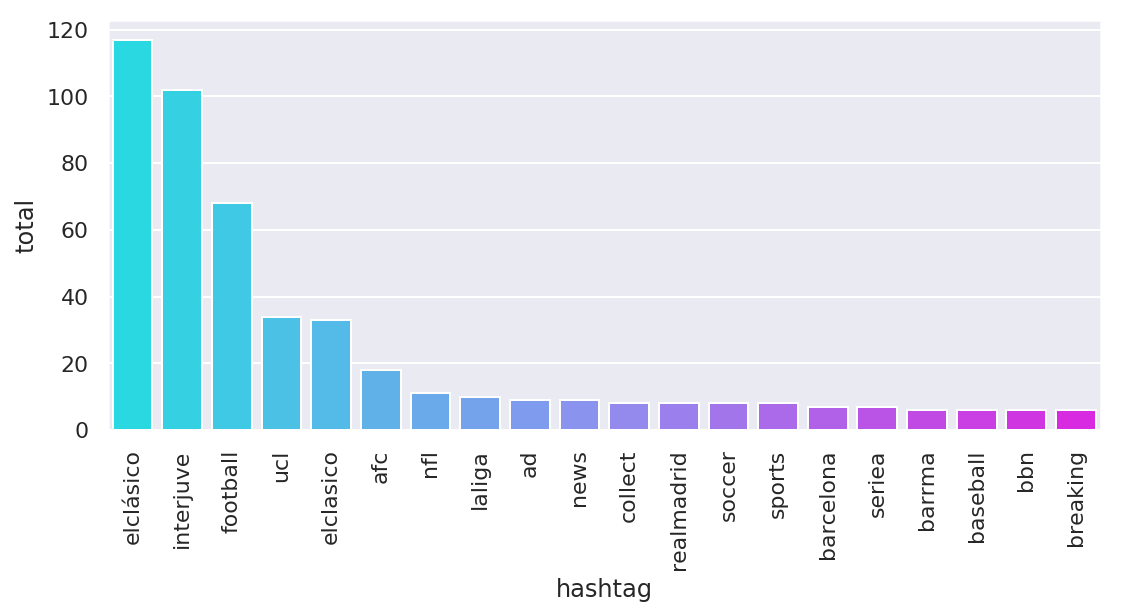

In [26]:
ssc.start()  # start the Spark streaming

In [ ]:
ssc.stop()


<hr style="height:2px; border:none; color:#000; background-color:#000;">

# Spark 2.x: Structured Streaming
* Spark Streaming vs. Structured Streaming:  
https://dzone.com/articles/spark-streaming-vs-structured-streaming
* Spark: RDD vs DataFrames:  
https://blog.knoldus.com/spark-rdd-vs-dataframes/
* Structured Streaming Programming Guide:  
https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html

<hr style="height:2px; border:none; color:#000; background-color:#000;">

# More Info 
* See Lesson 16 in [**Python Fundamentals LiveLessons** here on O'Reilly Online Learning](https://learning.oreilly.com/videos/python-fundamentals/9780135917411)
* See Chapter 16 in [**Python for Programmers** on O'Reilly Online Learning](https://learning.oreilly.com/library/view/python-for-programmers/9780135231364/)
* See Chapter 17 in [**Intro Python for Computer Science and Data Science** on O'Reilly Online Learning](https://learning.oreilly.com/library/view/intro-to-python/9780135404799/)
* Interested in a print book? Check out:

| Python for Programmers<br>(640-page professional book) | Intro to Python for Computer<br>Science and Data Science<br>(880-page college textbook)
| :------ | :------
| <a href="https://amzn.to/2VvdnxE"><img alt="Python for Programmers cover" src="../images/PyFPCover.png" width="150" border="1"/></a> | <a href="https://amzn.to/2LiDCmt"><img alt="Intro to Python for Computer Science and Data Science: Learning to Program with AI, Big Data and the Cloud" src="../images/IntroToPythonCover.png" width="159" border="1"></a>

>Please **do not** purchase both books&mdash;_Python for Programmers_ is a subset of _Intro to Python for Computer Science and Data Science_

<hr style="height:2px; border:none; color:#000; background-color:#000;">

&copy; 2019 by Pearson Education, Inc. All Rights Reserved. The content in this notebook is based on the book [**Python for Programmers**](https://amzn.to/2VvdnxE).